# Field Analysis


In [1]:
import shelve

import pandas as pd
import missingno

In [2]:
pd.set_option("display.max_columns", None)

## Load & Display Flattened Data


In [3]:
with shelve.open("../data/raw/fields/fields.shelf") as db:
    with shelve.open("../data/processed/summary_stats.shelf", writeback=True) as stats:
        for key in db.keys():
            data = db.get(key)
            stats[key] = pd.Series(data).describe()
            print(f"Finished describing {key}")

Finished describing protocolSection.identificationModule.nctId
Finished describing protocolSection.identificationModule.orgStudyIdInfo.id
Finished describing protocolSection.identificationModule.organization.fullName
Finished describing protocolSection.identificationModule.organization.class
Finished describing protocolSection.identificationModule.briefTitle
Finished describing protocolSection.identificationModule.officialTitle
Finished describing protocolSection.statusModule.statusVerifiedDate
Finished describing protocolSection.statusModule.overallStatus
Finished describing protocolSection.statusModule.expandedAccessInfo.hasExpandedAccess
Finished describing protocolSection.statusModule.startDateStruct.date
Finished describing protocolSection.statusModule.startDateStruct.type
Finished describing protocolSection.statusModule.primaryCompletionDateStruct.date
Finished describing protocolSection.statusModule.primaryCompletionDateStruct.type
Finished describing protocolSection.statusModul

## Load Data

Make sure to first download the fields by running the [`download_fields.py`](../scripts/download_fields.py) script. After that, extract the raw data from a `.pkl` file. The reason for storing the fields in a `.pkl` file is to ensure that data structures such as lists do not get converted into strings.


In [ ]:
df = pd.read_pickle("../fields.pkl")
df

,hasResults,protocolSection.identificationModule.nctId,protocolSection.identificationModule.orgStudyIdInfo.id,protocolSection.identificationModule.secondaryIdInfos,protocolSection.identificationModule.organization.fullName,protocolSection.identificationModule.organization.class,protocolSection.identificationModule.briefTitle,protocolSection.identificationModule.officialTitle,protocolSection.statusModule.statusVerifiedDate,protocolSection.statusModule.overallStatus,protocolSection.statusModule.expandedAccessInfo.hasExpandedAccess,protocolSection.statusModule.startDateStruct.date,protocolSection.statusModule.primaryCompletionDateStruct.date,protocolSection.statusModule.primaryCompletionDateStruct.type,protocolSection.statusModule.completionDateStruct.date,protocolSection.statusModule.completionDateStruct.type,protocolSection.statusModule.studyFirstSubmitDate,protocolSection.statusModule.studyFirstSubmitQcDate,protocolSection.statusModule.studyFirstPostDateStruct.date,protocolSection.statusModule.studyFirstPostDateStruct.type,protocolSection.statusModule.lastUpdateSubmitDate,protocolSection.statusModule.lastUpdatePostDateStruct.date,protocolSection.statusModule.lastUpdatePostDateStruct.type,protocolSection.sponsorCollaboratorsModule.responsibleParty.type,protocolSection.sponsorCollaboratorsModule.leadSponsor.name,protocolSection.sponsorCollaboratorsModule.leadSponsor.class,protocolSection.sponsorCollaboratorsModule.collaborators,protocolSection.descriptionModule.briefSummary,protocolSection.descriptionModule.detailedDescription,protocolSection.conditionsModule.conditions,protocolSection.conditionsModule.keywords,protocolSection.designModule.studyType,protocolSection.designModule.phases,protocolSection.designModule.designInfo.primaryPurpose,protocolSection.designModule.designInfo.maskingInfo.masking,protocolSection.armsInterventionsModule.interventions,protocolSection.outcomesModule.primaryOutcomes,protocolSection.outcomesModule.secondaryOutcomes,protocolSection.eligibilityModule.eligibilityCriteria,protocolSection.eligibilityModule.healthyVolunteers,protocolSection.eligibilityModule.sex,protocolSection.eligibilityModule.minimumAge,protocolSection.eligibilityModule.maximumAge,protocolSection.eligibilityModule.stdAges,protocolSection.contactsLocationsModule.overallOfficials,protocolSection.contactsLocationsModule.locations,derivedSection.miscInfoModule.versionHolder,derivedSection.conditionBrowseModule.meshes,derivedSection.conditionBrowseModule.ancestors,derivedSection.conditionBrowseModule.browseLeaves,derivedSection.conditionBrowseModule.browseBranches,derivedSection.interventionBrowseModule.meshes,derivedSection.interventionBrowseModule.ancestors,derivedSection.interventionBrowseModule.browseLeaves,derivedSection.interventionBrowseModule.browseBranches,protocolSection.designModule.designInfo.allocation,protocolSection.designModule.designInfo.interventionModel,protocolSection.designModule.enrollmentInfo.count,protocolSection.designModule.enrollmentInfo.type,protocolSection.oversightModule.oversightHasDmc,protocolSection.armsInterventionsModule.armGroups,protocolSection.referencesModule.references,protocolSection.statusModule.startDateStruct.type,protocolSection.oversightModule.isFdaRegulatedDrug,protocolSection.oversightModule.isFdaRegulatedDevice,protocolSection.designModule.designInfo.interventionModelDescription,protocolSection.designModule.designInfo.maskingInfo.whoMasked,protocolSection.ipdSharingStatementModule.ipdSharing,protocolSection.statusModule.lastKnownStatus,protocolSection.designModule.designInfo.maskingInfo.maskingDescription,protocolSection.identificationModule.acronym,protocolSection.statusModule.resultsFirstSubmitDate,protocolSection.statusModule.resultsFirstSubmitQcDate,protocolSection.statusModule.resultsFirstPostDateStruct.date,protocolSection.statusModule.resultsFirstPostDateStruct.type,resultsSection.participantFlowModule.preAssignmentDetails,resultsSection.participantFlowModule.recruitmentDetails,results

## Data Processing

Certain fields in the dataset are deeply nested and contain repeated values. For instance, the "facility" field could contain the locations of multiple facilities. Therefore, we need to extract the complex columns which contain such nested data, and flatten and analyze them separately.

### Extract Complex Fields

First, we find all the fields for the columns which contain nested data.


In [ ]:
def is_complex_column(series: pd.Series) -> bool:
    """
    Helper function to check if a series is complex (i.e. contains nested data).

    Args:
        series (pd.Series): Pandas Series object.

    Returns:
        bool: True if series is complex, otherwise False.
    """
    if isinstance(series, list):
        for cell in series:
            if isinstance(cell, dict):
                return True
    return False


def get_complex_fields(df: pd.DataFrame) -> list[str]:
    """
    Retrieves the complex columns in a gvien dataframe.

    Args:
        df (pd.DataFrame): Pandas DataFrame object to filter.

    Returns:
        list[str]: The column names of all complex columns.
    """
    complex_columns = []
    for col in df.columns:
        if df[col].apply(is_complex_column).any():
            complex_columns.append(col)
    return complex_columns


complex_fields = get_complex_fields(df)
complex_fields

['protocolSection.identificationModule.secondaryIdInfos',
 'protocolSection.sponsorCollaboratorsModule.collaborators',
 'protocolSection.armsInterventionsModule.interventions',
 'protocolSection.outcomesModule.primaryOutcomes',
 'protocolSection.outcomesModule.secondaryOutcomes',
 'protocolSection.contactsLocationsModule.overallOfficials',
 'protocolSection.contactsLocationsModule.locations',
 'derivedSection.conditionBrowseModule.meshes',
 'derivedSection.conditionBrowseModule.ancestors',
 'derivedSection.conditionBrowseModule.browseLeaves',
 'derivedSection.conditionBrowseModule.browseBranches',
 'derivedSection.interventionBrowseModule.meshes',
 'derivedSection.interventionBrowseModule.ancestors',
 'derivedSection.interventionBrowseModule.browseLeaves',
 'derivedSection.interventionBrowseModule.browseBranches',
 'protocolSection.armsInterventionsModule.armGroups',
 'protocolSection.referencesModule.references',
 'resultsSection.participantFlowModule.groups',
 'resultsSection.partici

### Complex Columns

Display the columns which contain nested data.


In [ ]:
complex_columns = df[complex_fields]
complex_columns

,protocolSection.identificationModule.secondaryIdInfos,protocolSection.sponsorCollaboratorsModule.collaborators,protocolSection.armsInterventionsModule.interventions,protocolSection.outcomesModule.primaryOutcomes,protocolSection.outcomesModule.secondaryOutcomes,protocolSection.contactsLocationsModule.overallOfficials,protocolSection.contactsLocationsModule.locations,derivedSection.conditionBrowseModule.meshes,derivedSection.conditionBrowseModule.ancestors,derivedSection.conditionBrowseModule.browseLeaves,derivedSection.conditionBrowseModule.browseBranches,derivedSection.interventionBrowseModule.meshes,derivedSection.interventionBrowseModule.ancestors,derivedSection.interventionBrowseModule.browseLeaves,derivedSection.interventionBrowseModule.browseBranches,protocolSection.armsInterventionsModule.armGroups,protocolSection.referencesModule.references,resultsSection.participantFlowModule.groups,resultsSection.participantFlowModule.periods,resultsSection.baselineCharacteristicsModule.groups,resultsSection.baselineCharacteristicsModule.denoms,resultsSection.baselineCharacteristicsModule.measures,resultsSection.outcomeMeasuresModule.outcomeMeasures,resultsSection.adverseEventsModule.eventGroups,resultsSection.adverseEventsModule.seriousEvents,resultsSection.adverseEventsModule.otherEvents,documentSection.largeDocumentModule.largeDocs,protocolSection.contactsLocationsModule.centralContacts,protocolSection.referencesModule.seeAlsoLinks,protocolSection.outcomesModule.otherOutcomes,annotationSection.annotationModule.unpostedAnnotation.unpostedEvents,derivedSection.miscInfoModule.submissionTracking.submissionInfos,protocolSection.referencesModule.availIpds,annotationSection.annotationModule.violationAnnotation.violationEvents
0,"[{'id': 'CDR0000340983', 'type': 'REGISTRY', '...","[{'name': 'National Cancer Institute (NCI)', '...","[{'type': 'BIOLOGICAL', 'name': 'sargramostim'}]",[{'measure': 'Cytogenetic response (complete a...,[{'measure': 'Toxicity as assessed by the Expa...,"[{'name': 'Istvan Molnar, MD', 'affiliation': ...","[{'facility': 'CCOP - Western Regional, Arizon...","[{'id': 'D000007938', 'term': 'Leukemia'}, {'i...","[{'id': 'D000009370', 'term': 'Neoplasms by Hi...","[{'id': 'M10945', 'name': 'Leukemia', 'asFound...","[{'abbrev': 'BC04', 'name': 'Neoplasms'}, {'ab...","[{'id': 'C000081222', 'term': 'Sargramostim'}]","[{'id': 'D000007155', 'term': 'Immunologic Fac...","[{'id': 'M257633', 'name': 'Molgramostim', 're...","[{'abbrev': 'ANeo', 'name': 'Antineoplastic Ag...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[{'id': 'HARECCTR0500057'}],NaN,"[{'type': 'DRUG', 'name': 'Vardenafil 10mg'}]",[{'measure': 'Mean maximal change of the stand...,[{'measure': 'Mean maximal post-baseline chang...,"[{'name': 'Chi Fai Ng, Dr', 'affiliation': 'De...","[{'facility': 'Prince of Wales Hospital', 'cit...","[{'id': 'D000007172', 'term': 'Erectile Dysfun...","[{'id': 'D000010335', 'term': 'Pathologic Proc...","[{'id': 'M10217', 'name': 'Erectile Dysfunctio...","[{'abbrev': 'BXS', 'name': 'Urinary Tract, Sex...","[{'id': 'D000069058', 'term': 'Vardenafil Dihy...","[{'id': 'D000014665', 'term': 'Vasodilator Age...","[{'id': 'M19586', 'name': 'Doxazosin', 'releva...","[{'abbrev': 'AnAg', 'name': 'Antihypertensive ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,"[{'type': 'OTHER', 'name': 'Distillation based...",[{'measure': 'To demonstrate a reduction in th...,[{'measure': 'To explore changes from baseline...,"[{'name': 'Katarzyna Jarus-Dziedzic, MD', 'aff...","[{'facility': 'MTZ Clinical Research Inc.', 'c...",NaN,NaN,NaN,NaN,NaN,NaN,"[{'id': 'M12478', 'name': 'Nicotine', 'relevan...","[{'abbrev': 'All', 'name': 'All Drugs and Chem...","[{'label': '1. SMAR', 'type': 'EXPERIMENTAL', ...","[{'pmid': '26817490', 'type': 'RESULT', 'citat...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[{'id': 'IRB00207577', 'type': 'OTHER', 'domai...","[{'nam

### Original Data

We also remove the complex fields from our original data.


In [ ]:
simple_columns = df.drop(complex_fields, axis=1)
simple_columns

,hasResults,protocolSection.identificationModule.nctId,protocolSection.identificationModule.orgStudyIdInfo.id,protocolSection.identificationModule.organization.fullName,protocolSection.identificationModule.organization.class,protocolSection.identificationModule.briefTitle,protocolSection.identificationModule.officialTitle,protocolSection.statusModule.statusVerifiedDate,protocolSection.statusModule.overallStatus,protocolSection.statusModule.expandedAccessInfo.hasExpandedAccess,protocolSection.statusModule.startDateStruct.date,protocolSection.statusModule.primaryCompletionDateStruct.date,protocolSection.statusModule.primaryCompletionDateStruct.type,protocolSection.statusModule.completionDateStruct.date,protocolSection.statusModule.completionDateStruct.type,protocolSection.statusModule.studyFirstSubmitDate,protocolSection.statusModule.studyFirstSubmitQcDate,protocolSection.statusModule.studyFirstPostDateStruct.date,protocolSection.statusModule.studyFirstPostDateStruct.type,protocolSection.statusModule.lastUpdateSubmitDate,protocolSection.statusModule.lastUpdatePostDateStruct.date,protocolSection.statusModule.lastUpdatePostDateStruct.type,protocolSection.sponsorCollaboratorsModule.responsibleParty.type,protocolSection.sponsorCollaboratorsModule.leadSponsor.name,protocolSection.sponsorCollaboratorsModule.leadSponsor.class,protocolSection.descriptionModule.briefSummary,protocolSection.descriptionModule.detailedDescription,protocolSection.conditionsModule.conditions,protocolSection.conditionsModule.keywords,protocolSection.designModule.studyType,protocolSection.designModule.phases,protocolSection.designModule.designInfo.primaryPurpose,protocolSection.designModule.designInfo.maskingInfo.masking,protocolSection.eligibilityModule.eligibilityCriteria,protocolSection.eligibilityModule.healthyVolunteers,protocolSection.eligibilityModule.sex,protocolSection.eligibilityModule.minimumAge,protocolSection.eligibilityModule.maximumAge,protocolSection.eligibilityModule.stdAges,derivedSection.miscInfoModule.versionHolder,protocolSection.designModule.designInfo.allocation,protocolSection.designModule.designInfo.interventionModel,protocolSection.designModule.enrollmentInfo.count,protocolSection.designModule.enrollmentInfo.type,protocolSection.oversightModule.oversightHasDmc,protocolSection.statusModule.startDateStruct.type,protocolSection.oversightModule.isFdaRegulatedDrug,protocolSection.oversightModule.isFdaRegulatedDevice,protocolSection.designModule.designInfo.interventionModelDescription,protocolSection.designModule.designInfo.maskingInfo.whoMasked,protocolSection.ipdSharingStatementModule.ipdSharing,protocolSection.statusModule.lastKnownStatus,protocolSection.designModule.designInfo.maskingInfo.maskingDescription,protocolSection.identificationModule.acronym,protocolSection.statusModule.resultsFirstSubmitDate,protocolSection.statusModule.resultsFirstSubmitQcDate,protocolSection.statusModule.resultsFirstPostDateStruct.date,protocolSection.statusModule.resultsFirstPostDateStruct.type,resultsSection.participantFlowModule.preAssignmentDetails,resultsSection.participantFlowModule.recruitmentDetails,resultsSection.adverseEventsModule.frequencyThreshold,resultsSection.adverseEventsModule.timeFrame,resultsSection.adverseEventsModule.description,resultsSection.moreInfoModule.certainAgreement.piSponsorEmployee,resultsSection.moreInfoModule.certainAgreement.restrictiveAgreement,resultsSection.moreInfoModule.pointOfContact.title,resultsSection.moreInfoModule.pointOfContact.organization,resultsSection.moreInfoModule.pointOfContact.email,resultsSection.moreInfoModule.pointOfContact.phone,protocolSection.sponsorCollaboratorsModule.responsibleParty.investigatorFullName,protocolSection.sponsorCollaboratorsModule.responsibleParty.investigatorTitle,protocolSection.sponsorCollaboratorsModule.responsibleParty.investigatorAffiliation,protocolSection.oversightModule.isUsExport,protocolSection.ipdSharingStatementModule.description,protocolSection.ipdSharingStatementMo

In [ ]:
normalized_df = pd.DataFrame()
sample = complex_columns.head(10)

for _, row in sample.iterrows():
    for col in row.index:
        cell = row[col]
        if isinstance(cell, list):
            for item in cell:
                expanded = pd.json_normalize(item)
                expanded.columns = [f"{col}.{c}" for c in expanded.columns]
                normalized_df = pd.concat([normalized_df, expanded], ignore_index=True)

normalized_df

,protocolSection.identificationModule.secondaryIdInfos.id,protocolSection.identificationModule.secondaryIdInfos.type,protocolSection.identificationModule.secondaryIdInfos.domain,protocolSection.sponsorCollaboratorsModule.collaborators.name,protocolSection.sponsorCollaboratorsModule.collaborators.class,protocolSection.armsInterventionsModule.interventions.type,protocolSection.armsInterventionsModule.interventions.name,protocolSection.outcomesModule.primaryOutcomes.measure,protocolSection.outcomesModule.secondaryOutcomes.measure,protocolSection.contactsLocationsModule.overallOfficials.name,protocolSection.contactsLocationsModule.overallOfficials.affiliation,protocolSection.contactsLocationsModule.overallOfficials.role,protocolSection.contactsLocationsModule.locations.facility,protocolSection.contactsLocationsModule.locations.city,protocolSection.contactsLocationsModule.locations.state,protocolSection.contactsLocationsModule.locations.zip,protocolSection.contactsLocationsModule.locations.country,protocolSection.contactsLocationsModule.locations.geoPoint.lat,protocolSection.contactsLocationsModule.locations.geoPoint.lon,derivedSection.conditionBrowseModule.meshes.id,derivedSection.conditionBrowseModule.meshes.term,derivedSection.conditionBrowseModule.ancestors.id,derivedSection.conditionBrowseModule.ancestors.term,derivedSection.conditionBrowseModule.browseLeaves.id,derivedSection.conditionBrowseModule.browseLeaves.name,derivedSection.conditionBrowseModule.browseLeaves.asFound,derivedSection.conditionBrowseModule.browseLeaves.relevance,derivedSection.conditionBrowseModule.browseBranches.abbrev,derivedSection.conditionBrowseModule.browseBranches.name,derivedSection.interventionBrowseModule.meshes.id,derivedSection.interventionBrowseModule.meshes.term,derivedSection.interventionBrowseModule.ancestors.id,derivedSection.interventionBrowseModule.ancestors.term,derivedSection.interventionBrowseModule.browseLeaves.id,derivedSection.interventionBrowseModule.browseLeaves.name,derivedSection.interventionBrowseModule.browseLeaves.relevance,derivedSection.interventionBrowseModule.browseLeaves.asFound,derivedSection.interventionBrowseModule.browseBranches.abbrev,derivedSection.interventionBrowseModule.browseBranches.name,protocolSection.outcomesModule.primaryOutcomes.timeFrame,protocolSection.outcomesModule.secondaryOutcomes.timeFrame,protocolSection.armsInterventionsModule.interventions.description,protocolSection.armsInterventionsModule.interventions.armGroupLabels,protocolSection.armsInterventionsModule.armGroups.label,protocolSection.armsInterventionsModule.armGroups.type,protocolSection.armsInterventionsModule.armGroups.description,protocolSection.armsInterventionsModule.armGroups.interventionNames,protocolSection.referencesModule.references.pmid,protocolSection.referencesModule.references.type,protocolSection.referencesModule.references.citation,protocolSection.armsInterventionsModule.interventions.otherNames,protocolSection.outcomesModule.primaryOutcomes.description,protocolSection.outcomesModule.secondaryOutcomes.description,resultsSection.participantFlowModule.groups.id,resultsSection.participantFlowModule.groups.title,resultsSection.participantFlowModule.groups.description,resultsSection.participantFlowModule.periods.title,resultsSection.participantFlowModule.periods.milestones,resultsSection.participantFlowModule.periods.dropWithdraws,resultsSection.baselineCharacteristicsModule.groups.id,resultsSection.baselineCharacteristicsModule.groups.title,resultsSection.baselineCharacteristicsModule.groups.description,resultsSection.baselineCharacteristicsModule.denoms.units,resultsSection.baselineCharacteristicsModule.denoms.counts,resultsSection.baselineCharacteristicsModule.measures.title,resultsSection.baselineCharacteristicsModule.measures.paramType,resultsSection.baselineCharacteristicsModule.measures.dispersionType,resultsSection.baselineCharacteristicsModule.measures.unitOfMeasure,resultsSection.baselineCharacteristicsModule.measures.

## Summary Statistics


In [ ]:
simple_columns.head().describe(include="all")

,hasResults,protocolSection.identificationModule.nctId,protocolSection.identificationModule.orgStudyIdInfo.id,protocolSection.identificationModule.organization.fullName,protocolSection.identificationModule.organization.class,protocolSection.identificationModule.briefTitle,protocolSection.identificationModule.officialTitle,protocolSection.statusModule.statusVerifiedDate,protocolSection.statusModule.overallStatus,protocolSection.statusModule.expandedAccessInfo.hasExpandedAccess,protocolSection.statusModule.startDateStruct.date,protocolSection.statusModule.primaryCompletionDateStruct.date,protocolSection.statusModule.primaryCompletionDateStruct.type,protocolSection.statusModule.completionDateStruct.date,protocolSection.statusModule.completionDateStruct.type,protocolSection.statusModule.studyFirstSubmitDate,protocolSection.statusModule.studyFirstSubmitQcDate,protocolSection.statusModule.studyFirstPostDateStruct.date,protocolSection.statusModule.studyFirstPostDateStruct.type,protocolSection.statusModule.lastUpdateSubmitDate,protocolSection.statusModule.lastUpdatePostDateStruct.date,protocolSection.statusModule.lastUpdatePostDateStruct.type,protocolSection.sponsorCollaboratorsModule.responsibleParty.type,protocolSection.sponsorCollaboratorsModule.leadSponsor.name,protocolSection.sponsorCollaboratorsModule.leadSponsor.class,protocolSection.descriptionModule.briefSummary,protocolSection.descriptionModule.detailedDescription,protocolSection.conditionsModule.conditions,protocolSection.conditionsModule.keywords,protocolSection.designModule.studyType,protocolSection.designModule.phases,protocolSection.designModule.designInfo.primaryPurpose,protocolSection.designModule.designInfo.maskingInfo.masking,protocolSection.eligibilityModule.eligibilityCriteria,protocolSection.eligibilityModule.healthyVolunteers,protocolSection.eligibilityModule.sex,protocolSection.eligibilityModule.minimumAge,protocolSection.eligibilityModule.maximumAge,protocolSection.eligibilityModule.stdAges,derivedSection.miscInfoModule.versionHolder,protocolSection.designModule.designInfo.allocation,protocolSection.designModule.designInfo.interventionModel,protocolSection.designModule.enrollmentInfo.count,protocolSection.designModule.enrollmentInfo.type,protocolSection.oversightModule.oversightHasDmc,protocolSection.statusModule.startDateStruct.type,protocolSection.oversightModule.isFdaRegulatedDrug,protocolSection.oversightModule.isFdaRegulatedDevice,protocolSection.designModule.designInfo.interventionModelDescription,protocolSection.designModule.designInfo.maskingInfo.whoMasked,protocolSection.ipdSharingStatementModule.ipdSharing,protocolSection.statusModule.lastKnownStatus,protocolSection.designModule.designInfo.maskingInfo.maskingDescription,protocolSection.identificationModule.acronym,protocolSection.statusModule.resultsFirstSubmitDate,protocolSection.statusModule.resultsFirstSubmitQcDate,protocolSection.statusModule.resultsFirstPostDateStruct.date,protocolSection.statusModule.resultsFirstPostDateStruct.type,resultsSection.participantFlowModule.preAssignmentDetails,resultsSection.participantFlowModule.recruitmentDetails,resultsSection.adverseEventsModule.frequencyThreshold,resultsSection.adverseEventsModule.timeFrame,resultsSection.adverseEventsModule.description,resultsSection.moreInfoModule.certainAgreement.piSponsorEmployee,resultsSection.moreInfoModule.certainAgreement.restrictiveAgreement,resultsSection.moreInfoModule.pointOfContact.title,resultsSection.moreInfoModule.pointOfContact.organization,resultsSection.moreInfoModule.pointOfContact.email,resultsSection.moreInfoModule.pointOfContact.phone,protocolSection.sponsorCollaboratorsModule.responsibleParty.investigatorFullName,protocolSection.sponsorCollaboratorsModule.responsibleParty.investigatorTitle,protocolSection.sponsorCollaboratorsModule.responsibleParty.investigatorAffiliation,protocolSection.oversightModule.isUsExport,protocolSection.ipdSharingStatementModule.description,protocolSection.ipdSharingStatementMo

In [ ]:
normalized_df.describe(include="all")

,protocolSection.identificationModule.secondaryIdInfos.id,protocolSection.identificationModule.secondaryIdInfos.type,protocolSection.identificationModule.secondaryIdInfos.domain,protocolSection.sponsorCollaboratorsModule.collaborators.name,protocolSection.sponsorCollaboratorsModule.collaborators.class,protocolSection.armsInterventionsModule.interventions.type,protocolSection.armsInterventionsModule.interventions.name,protocolSection.outcomesModule.primaryOutcomes.measure,protocolSection.outcomesModule.secondaryOutcomes.measure,protocolSection.contactsLocationsModule.overallOfficials.name,protocolSection.contactsLocationsModule.overallOfficials.affiliation,protocolSection.contactsLocationsModule.overallOfficials.role,protocolSection.contactsLocationsModule.locations.facility,protocolSection.contactsLocationsModule.locations.city,protocolSection.contactsLocationsModule.locations.state,protocolSection.contactsLocationsModule.locations.zip,protocolSection.contactsLocationsModule.locations.country,protocolSection.contactsLocationsModule.locations.geoPoint.lat,protocolSection.contactsLocationsModule.locations.geoPoint.lon,derivedSection.conditionBrowseModule.meshes.id,derivedSection.conditionBrowseModule.meshes.term,derivedSection.conditionBrowseModule.ancestors.id,derivedSection.conditionBrowseModule.ancestors.term,derivedSection.conditionBrowseModule.browseLeaves.id,derivedSection.conditionBrowseModule.browseLeaves.name,derivedSection.conditionBrowseModule.browseLeaves.asFound,derivedSection.conditionBrowseModule.browseLeaves.relevance,derivedSection.conditionBrowseModule.browseBranches.abbrev,derivedSection.conditionBrowseModule.browseBranches.name,derivedSection.interventionBrowseModule.meshes.id,derivedSection.interventionBrowseModule.meshes.term,derivedSection.interventionBrowseModule.ancestors.id,derivedSection.interventionBrowseModule.ancestors.term,derivedSection.interventionBrowseModule.browseLeaves.id,derivedSection.interventionBrowseModule.browseLeaves.name,derivedSection.interventionBrowseModule.browseLeaves.relevance,derivedSection.interventionBrowseModule.browseLeaves.asFound,derivedSection.interventionBrowseModule.browseBranches.abbrev,derivedSection.interventionBrowseModule.browseBranches.name,protocolSection.outcomesModule.primaryOutcomes.timeFrame,protocolSection.outcomesModule.secondaryOutcomes.timeFrame,protocolSection.armsInterventionsModule.interventions.description,protocolSection.armsInterventionsModule.interventions.armGroupLabels,protocolSection.armsInterventionsModule.armGroups.label,protocolSection.armsInterventionsModule.armGroups.type,protocolSection.armsInterventionsModule.armGroups.description,protocolSection.armsInterventionsModule.armGroups.interventionNames,protocolSection.referencesModule.references.pmid,protocolSection.referencesModule.references.type,protocolSection.referencesModule.references.citation,protocolSection.armsInterventionsModule.interventions.otherNames,protocolSection.outcomesModule.primaryOutcomes.description,protocolSection.outcomesModule.secondaryOutcomes.description,resultsSection.participantFlowModule.groups.id,resultsSection.participantFlowModule.groups.title,resultsSection.participantFlowModule.groups.description,resultsSection.participantFlowModule.periods.title,resultsSection.participantFlowModule.periods.milestones,resultsSection.participantFlowModule.periods.dropWithdraws,resultsSection.baselineCharacteristicsModule.groups.id,resultsSection.baselineCharacteristicsModule.groups.title,resultsSection.baselineCharacteristicsModule.groups.description,resultsSection.baselineCharacteristicsModule.denoms.units,resultsSection.baselineCharacteristicsModule.denoms.counts,resultsSection.baselineCharacteristicsModule.measures.title,resultsSection.baselineCharacteristicsModule.measures.paramType,resultsSection.baselineCharacteristicsModule.measures.dispersionType,resultsSection.baselineCharacteristicsModule.measures.unitOfMeasure,resultsSection.baselineCharacteristicsModule.measures.

<Axes: >

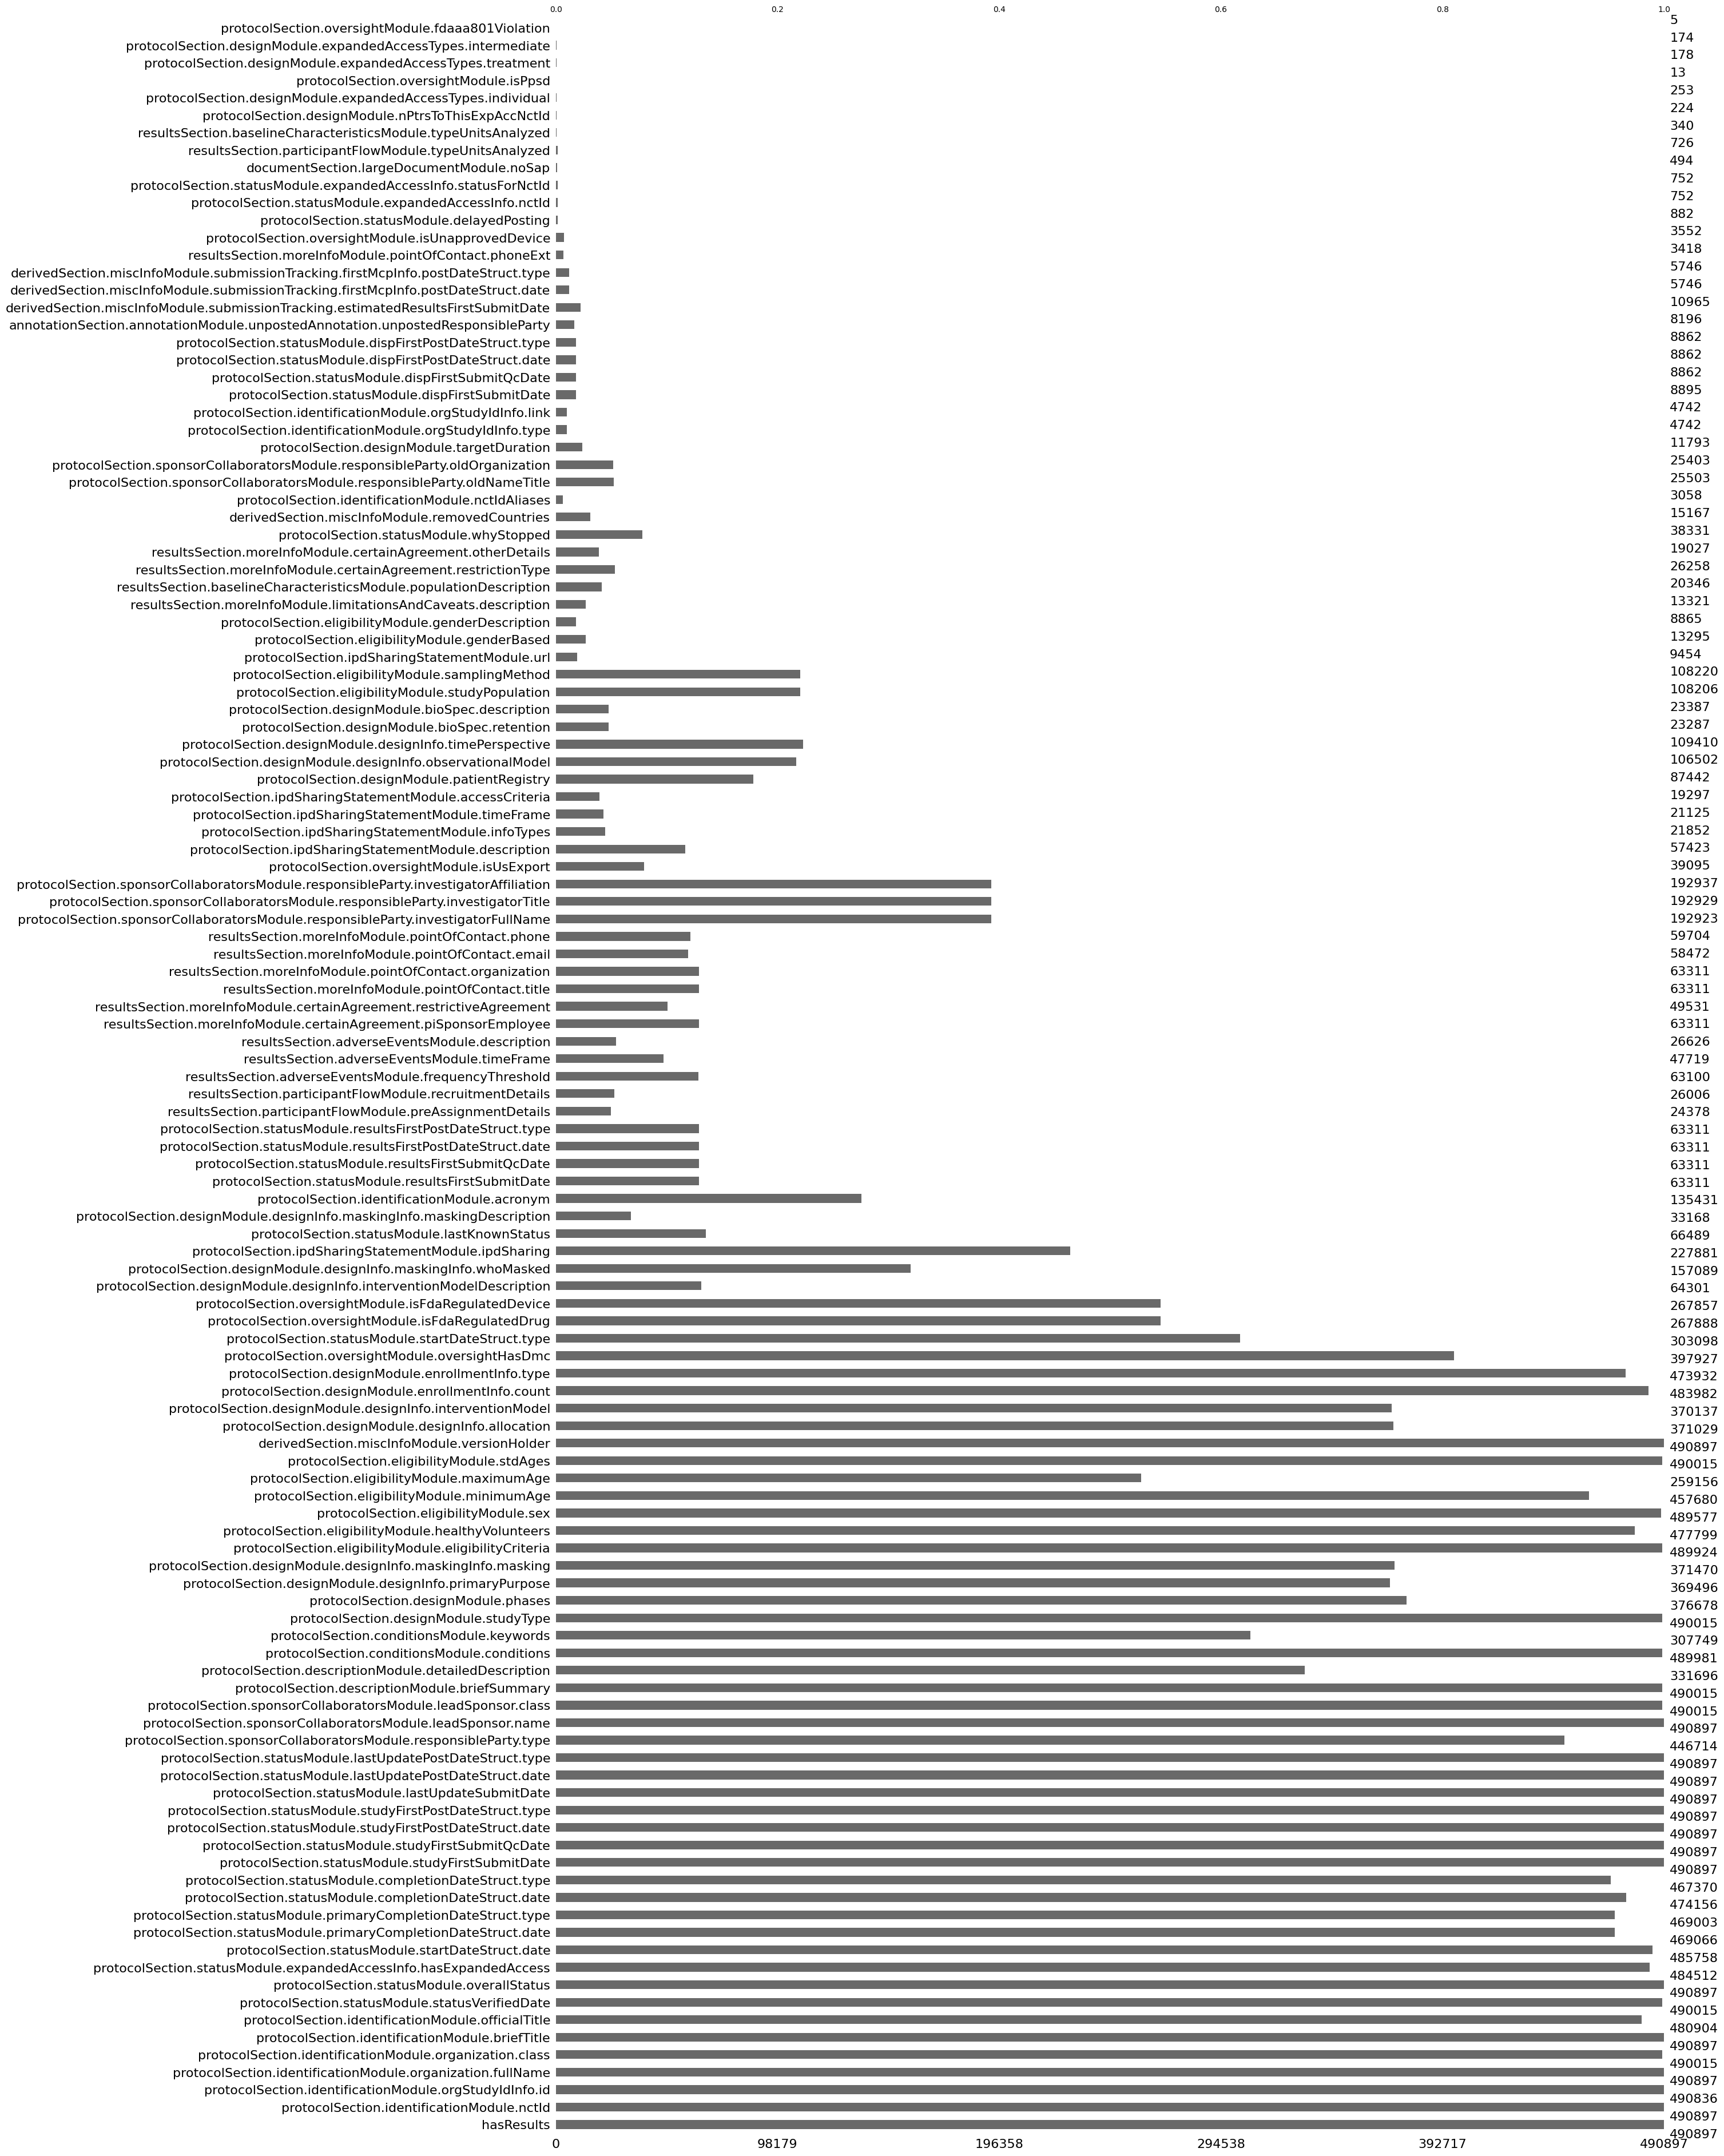

In [ ]:
missingno.bar(simple_columns)